## 보편적 처리

학습 이미지 알집
https://drive.google.com/file/d/1AUmFSaUl0D5PHhIrkJnwSmTO2IEWcyjj/view?usp=drive_link

csv파일
https://drive.google.com/file/d/14unQdO1j_LMzqKU-TTkK5MkqOqah6fOb/view?usp=drive_link

In [ ]:
import numpy as np
#이전에 처리해둔 사전과 전처리 라벨링 가져옴, zip파일 형태 다운
%cd /content/
!gdown 1AUmFSaUl0D5PHhIrkJnwSmTO2IEWcyjj --output train.zip

/content
Downloading...
From: https://drive.google.com/uc?id=1AUmFSaUl0D5PHhIrkJnwSmTO2IEWcyjj
To: /content/train.zip
 48% 6.50G/13.6G [01:06<00:42, 165MB/s]

In [ ]:
#압축해제
import zipfile
path_to_zip_file = '/content/train.zip'
directory_to_extract_to = 'train_img'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

FileNotFoundError: ignored

In [ ]:
!gdown 14unQdO1j_LMzqKU-TTkK5MkqOqah6fOb --output train.csv

Downloading...
From: https://drive.google.com/uc?id=14unQdO1j_LMzqKU-TTkK5MkqOqah6fOb
To: /content/train.csv
100% 159M/159M [00:01<00:00, 92.1MB/s]


파일들 넣음

## 백업 공간 설정

In [ ]:
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_name = "/content/drive/MyDrive/ai경진대회/model"

# 폴더가 존재하지 않는 경우에만 폴더를 생성합니다.
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [ ]:
#압축해제
import zipfile
path_to_zip_file = '/content/drive/MyDrive/ai경진대회/train_img.zip'
directory_to_extract_to = 'train_img'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

## Import

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [ ]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, divide=False, af_transform=None, i=0, j=0):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.divide = divide
        self.af_transform = af_transform
        self.i = i
        self.j = j

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        #증강 후 분할?, 분할 후 증강?
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # print("\n읽은 정보")
        # print(image.shape)
        # print(mask.shape)
        # print("이제 16분할 들어감!!\n")
        #여기 16분할이 들어가서 처리
        if self.divide:
          result_image = []
          result_mask = []

          stand = 224
          default = (1024-224*4)//2
          # print("\n 처리전")
          # print(image.shape)
          # print(mask.shape)
          # print(self.i*stand, self.i*stand+stand, self.j*stand, self.j*stand+stand)
          tmp_image = image[default+self.i*stand:default+self.i*stand+stand, default+self.j*stand:default+self.j*stand+stand, :]

          tmp_mask = mask[default+self.i*stand:default+self.i*stand+stand, default+self.j*stand:default+self.j*stand+stand]
          image = tmp_image
          mask = tmp_mask

          # print("\n처리끝")
          # print(image.shape)
          # print(mask.shape)
          # print(stand, default, default+self.i*stand, default+self.i*stand+stand, default+self.j*stand, default+self.j*stand+stand)

        #분할 후 증강
        if self.af_transform:
            augmented = self.af_transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            # print("이후 증강 완료")

        return image, mask

## Data Loader

## 그냥 한개를 변환해서 처리

In [ ]:
transform = A.Compose(
    [
        A.RandomCrop(224, 224),
        # A.Normalize(),
        A.Rotate(limit=60),
        A.CoarseDropout(max_holes=8, max_height=0.25, max_width=0.25, min_holes=3, min_height=0.125, min_width=0.125, fill_value=0, mask_fill_value=0, p=1),
        ToTensorV2()
    ]

)

dataset = SatelliteDataset(csv_file='/content/train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
# DataLoader에서 일부 미니배치를 얻기 위해 iter() 함수 사용
data_iterator = iter(dataloader)

# 첫 번째 미니배치 얻기
mini_batch = next(data_iterator)

# 미니배치의 이미지와 마스크를 얻음
images, masks = mini_batch[0], mini_batch[1]

# # 미니배치의 이미지와 마스크 확인
print("이미지 배치 크기:", images.shape)  # (batch_size, channels, height, width)
print("마스크 배치 크기:", masks.shape)  # (batch_size, height, width)

image, mask = images[0, :,:,:], masks[0,:,:]

이미지 배치 크기: torch.Size([16, 3, 224, 224])
마스크 배치 크기: torch.Size([16, 224, 224])


4239
[[155  92]
 [155 134]
 [156 134]
 [156 135]
 [157 134]
 [158 134]
 [159 134]
 [160 134]
 [160 135]
 [161 134]]


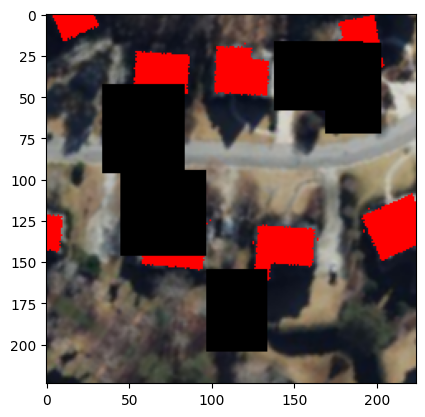

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
idx = 1
# 이미지 텐서를 NumPy 배열로 변환
image_np = images[idx].permute(1, 2, 0).numpy()

# 이미지 출력
plt.imshow(image_np)

# 마스크 정보를 이미지에 추가
mask_np = masks[idx].numpy()
# print(mask_np.shape)
mask_indices = np.where(mask_np != 0)
mask_indices = np.stack(mask_indices, axis=1)  # 2차원 배열로 변환
print(len(mask_indices))
print(mask_indices[-10:])
# 좌표들을 빨간색으로 표시
for coord in mask_indices:
    image_np[coord[0], coord[1]] = [255, 0, 0]  # 빨간색 (R, G, B)

# 이미지 출력
plt.imshow(image_np)
plt.show()


## 16분할 처리

In [ ]:
transform = A.Compose(
    [
        A.Resize(1024, 1024),
        A.Rotate(limit=30)
    ]
)

#회전 16분할 후 cutout처리
af_transform = A.Compose(
    [
        A.CoarseDropout(max_holes=8, max_height=56, max_width=56, min_holes=3, min_height=28, min_width=28, fill_value=0, mask_fill_value=0, p=1),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=1, j=1)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
# DataLoader에서 일부 미니배치를 얻기 위해 iter() 함수 사용
data_iterator = iter(dataloader)

# 첫 번째 미니배치 얻기
mini_batch = next(data_iterator)

# 미니배치의 이미지와 마스크를 얻음
images, masks = mini_batch[0], mini_batch[1]

# # 미니배치의 이미지와 마스크 확인
print("이미지 배치 크기:", images.shape)  # (batch_size, channels, height, width)
print("마스크 배치 크기:", masks.shape)  # (batch_size, height, width)

image, mask = images[0, :,:,:], masks[0,:,:]

이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료이후 증강 완료

이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이미지 배치 크기: torch.Size([16, 3, 224, 224])
마스크 배치 크기: torch.Size([16, 224, 224])
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료
이후 증강 완료


0
[]


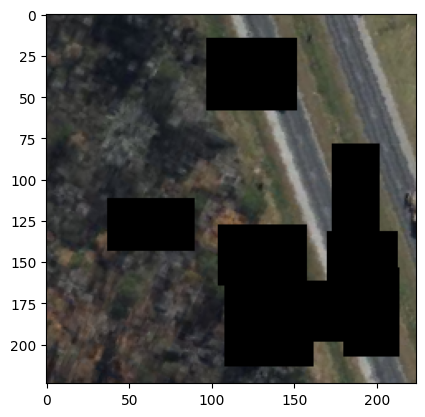

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
idx = 0
# 이미지 텐서를 NumPy 배열로 변환
image_np = images[idx].permute(1, 2, 0).numpy()

# 이미지 출력
plt.imshow(image_np)

# 마스크 정보를 이미지에 추가
mask_np = masks[idx].numpy()
# print(mask_np.shape)
mask_indices = np.where(mask_np != 0)
mask_indices = np.stack(mask_indices, axis=1)  # 2차원 배열로 변환
print(len(mask_indices))
print(mask_indices[-10:])
# 좌표들을 빨간색으로 표시
for coord in mask_indices:
    image_np[coord[0], coord[1]] = [255, 0, 0]  # 빨간색 (R, G, B)

# 이미지 출력
plt.imshow(image_np)
plt.show()


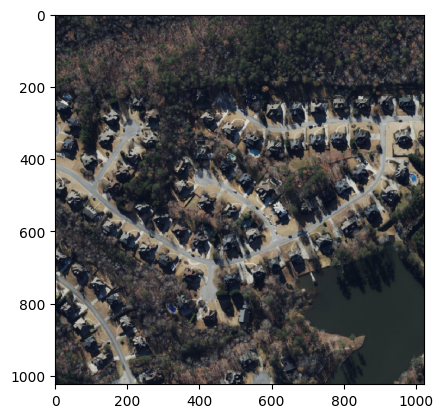

In [ ]:
import matplotlib.pyplot as plt
import cv2
idx = 1
# 이미지 파일 로드
image_path = f'/content/train_img/TRAIN_000{idx}.png'
# image_path = '/content/TEST_00000.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# 이미지 출력
plt.imshow(image)
# plt.axis('off')  # 축 제거
plt.show()


## Define Model

In [ ]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

## 학습기준 설정

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed


# def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
#     '''
#     mask_rle: run-length as string formatted (start length)
#     shape: (height,width) of array to return
#     Returns numpy array, 1 - mask, 0 - background
#     '''
#     if mask_rle == -1:
#         return np.zeros(shape)

#     s = mask_rle.split()
#     starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
#     starts -= 1
#     ends = starts + lengths
#     img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
#     for lo, hi in zip(starts, ends):
#         img[lo:hi] = 1
#     return img.reshape(shape)


# def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
#     '''
#     Calculate Dice Score between two binary masks.
#     '''
#     intersection = np.sum(prediction * ground_truth)
#     return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)

import torch

def dice_loss(prediction, ground_truth, weight=2.0, smooth=1e-7):
    intersection = torch.sum(prediction * ground_truth)
    sum_prediction = torch.sum(prediction)
    sum_ground_truth = torch.sum(ground_truth)
    dice_score = (2.0 * intersection + smooth) / (sum_prediction + sum_ground_truth + smooth)
    loss = 1.0 - dice_score
    if sum_ground_truth == 0 and sum_prediction>0: #없는데 있다고 해서 가중치 반영
      loss = weight*loss
    return loss

# 나머지 코드는 동일하게 유지됩니다.


criterion = dice_loss

## Model Train

In [ ]:
transform = A.Compose(
    [
        A.RandomCrop(224, 224),
        # A.Normalize(),
        # A.GaussianBlur(p=0.5),
        A.Rotate(limit=60),
        A.CoarseDropout(max_holes=8, max_height=0.25, max_width=0.25, min_holes=3, min_height=0.125, min_width=0.125, fill_value=0, mask_fill_value=0, p=0.5),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='/content/train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
import shutil
# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = dice_loss #dice_score평가기준이지만 더 좋지 않음!
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(10):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

    # 모델 상태, 옵티마이저 상태, 에포크 손실 등을 딕셔너리로 저장합니다.
    # 주석 처리된 부분들을 다시 활성화하여 모델과 옵티마이저 상태를 저장합니다.
    checkpoint = {
        'epoch': epoch,
        'model_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'epoch_loss': epoch_loss
    }

    # 위에서 정의한 딕셔너리를 해당 경로에 저장합니다.
    torch.save(checkpoint, f'/content/model{epoch}.pth')
    #저장, 다운
    if epoch % 10 == 9:
      source_file = f'/content/model{epoch}.pth'
      shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/basemodel_final{epoch}.pth')

100%|██████████| 447/447 [04:54<00:00,  1.52it/s]


Epoch 1, Loss: 0.1796885262716403


100%|██████████| 447/447 [05:12<00:00,  1.43it/s]


Epoch 2, Loss: 0.1428444003748814


100%|██████████| 447/447 [05:39<00:00,  1.32it/s]


Epoch 3, Loss: 0.14334143833226007


100%|██████████| 447/447 [04:58<00:00,  1.50it/s]


Epoch 4, Loss: 0.142057394246327


100%|██████████| 447/447 [04:49<00:00,  1.55it/s]


Epoch 5, Loss: 0.12540376198871825


100%|██████████| 447/447 [04:51<00:00,  1.54it/s]


Epoch 6, Loss: 0.11430598691239187


100%|██████████| 447/447 [04:51<00:00,  1.53it/s]


Epoch 7, Loss: 0.11325506679297027


100%|██████████| 447/447 [04:44<00:00,  1.57it/s]


Epoch 8, Loss: 0.10645986266717548


100%|██████████| 447/447 [04:46<00:00,  1.56it/s]


Epoch 9, Loss: 0.10013609986243899


100%|██████████| 447/447 [04:49<00:00,  1.54it/s]


Epoch 10, Loss: 0.09906903744343944


In [ ]:
# 체크포인트 파일을 로드합니다.
epoch = 9
checkpoint = torch.load(f'/content/drive/MyDrive/ai경진대회/model/basesubmit_randomcrop_rotate_cutout{epoch}.pth')

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 이전 학습 상태를 모델과 옵티마이저에 적용합니다.
model.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
epoch = checkpoint['epoch']
epoch_loss = checkpoint['epoch_loss']


In [ ]:
import shutil
# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()

# training loop
for epoch in range(10, 200):  # 계속해서 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

    #5배수마다 저장, 백업
    if epoch % 5 == 4:

      # 모델 상태, 옵티마이저 상태, 에포크 손실 등을 딕셔너리로 저장합니다.
      # 주석 처리된 부분들을 다시 활성화하여 모델과 옵티마이저 상태를 저장합니다.
      checkpoint = {
          'epoch': epoch,
          'model_dict': model.state_dict(),
          'optimizer_dict': optimizer.state_dict(),
          'epoch_loss': epoch_loss
      }

      # 위에서 정의한 딕셔너리를 해당 경로에 저장합니다.
      source_file = f'/content/model{epoch}.pth'
      torch.save(checkpoint, source_file)

      #백업합니다.
      shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/basesubmit_randomcrop_rotate_cutout{epoch}.pth')

100%|██████████| 447/447 [04:45<00:00,  1.57it/s]


Epoch 11, Loss: 0.10890019721699508


100%|██████████| 447/447 [04:31<00:00,  1.65it/s]


Epoch 12, Loss: 0.10006983721966312


100%|██████████| 447/447 [04:32<00:00,  1.64it/s]


Epoch 13, Loss: 0.09618672543524096


100%|██████████| 447/447 [04:32<00:00,  1.64it/s]


Epoch 14, Loss: 0.09426318479897726


100%|██████████| 447/447 [04:30<00:00,  1.65it/s]


Epoch 15, Loss: 0.09424122245836444


100%|██████████| 447/447 [04:34<00:00,  1.63it/s]


Epoch 16, Loss: 0.09293910882683674


100%|██████████| 447/447 [04:30<00:00,  1.65it/s]


Epoch 17, Loss: 0.09210398330267777


100%|██████████| 447/447 [04:31<00:00,  1.64it/s]


Epoch 18, Loss: 0.08845667135162108


100%|██████████| 447/447 [04:31<00:00,  1.65it/s]


Epoch 19, Loss: 0.08957161837709564


100%|██████████| 447/447 [04:35<00:00,  1.62it/s]


Epoch 20, Loss: 0.08926659279088313


100%|██████████| 447/447 [04:37<00:00,  1.61it/s]


Epoch 21, Loss: 0.08858383416929501


100%|██████████| 447/447 [04:32<00:00,  1.64it/s]


Epoch 22, Loss: 0.08730156400076361


100%|██████████| 447/447 [04:33<00:00,  1.64it/s]


Epoch 23, Loss: 0.08734987892410499


100%|██████████| 447/447 [04:34<00:00,  1.63it/s]


Epoch 24, Loss: 0.0869642318011797


100%|██████████| 447/447 [04:38<00:00,  1.60it/s]


Epoch 25, Loss: 0.08894447200583665


100%|██████████| 447/447 [04:37<00:00,  1.61it/s]


Epoch 26, Loss: 0.08418129465357302


100%|██████████| 447/447 [04:40<00:00,  1.59it/s]


Epoch 27, Loss: 0.08347792470498507


100%|██████████| 447/447 [04:35<00:00,  1.62it/s]


Epoch 28, Loss: 0.08895709613958995


100%|██████████| 447/447 [04:36<00:00,  1.62it/s]


Epoch 29, Loss: 0.08190135110244655


100%|██████████| 447/447 [04:26<00:00,  1.68it/s]


Epoch 30, Loss: 0.08109927991659316


100%|██████████| 447/447 [04:26<00:00,  1.68it/s]


Epoch 31, Loss: 0.09129112040919879


100%|██████████| 447/447 [04:27<00:00,  1.67it/s]


Epoch 32, Loss: 0.09251322136395997


100%|██████████| 447/447 [04:26<00:00,  1.68it/s]


Epoch 33, Loss: 0.08644740944374062


100%|██████████| 447/447 [04:26<00:00,  1.68it/s]


Epoch 34, Loss: 0.08494838916382


100%|██████████| 447/447 [04:25<00:00,  1.69it/s]


Epoch 35, Loss: 0.08021896376672474


100%|██████████| 447/447 [04:26<00:00,  1.67it/s]


Epoch 36, Loss: 0.08486558082961462


100%|██████████| 447/447 [04:27<00:00,  1.67it/s]


Epoch 37, Loss: 0.08220368246204102


100%|██████████| 447/447 [04:28<00:00,  1.66it/s]


Epoch 38, Loss: 0.07947573263273143


100%|██████████| 447/447 [04:25<00:00,  1.68it/s]


Epoch 39, Loss: 0.08566805460309022


100%|██████████| 447/447 [04:27<00:00,  1.67it/s]


Epoch 40, Loss: 0.08107152097843905


100%|██████████| 447/447 [04:30<00:00,  1.66it/s]


Epoch 41, Loss: 0.07969061801964271


100%|██████████| 447/447 [04:27<00:00,  1.67it/s]


Epoch 42, Loss: 0.11027866551106674


100%|██████████| 447/447 [04:28<00:00,  1.67it/s]


Epoch 43, Loss: 0.0919035202771492


100%|██████████| 447/447 [04:26<00:00,  1.68it/s]


Epoch 44, Loss: 0.09021706939560321


100%|██████████| 447/447 [04:31<00:00,  1.65it/s]


Epoch 45, Loss: 0.08447524250570426


100%|██████████| 447/447 [04:28<00:00,  1.67it/s]


Epoch 46, Loss: 0.08326381616611075


100%|██████████| 447/447 [04:29<00:00,  1.66it/s]


Epoch 47, Loss: 0.08152358026829208


100%|██████████| 447/447 [04:29<00:00,  1.66it/s]


Epoch 48, Loss: 0.07986053475230866


100%|██████████| 447/447 [04:30<00:00,  1.65it/s]


Epoch 49, Loss: 0.09396014428828786


100%|██████████| 447/447 [04:32<00:00,  1.64it/s]


Epoch 50, Loss: 0.08359938826603644


100%|██████████| 447/447 [04:30<00:00,  1.65it/s]


Epoch 51, Loss: 0.07894463894651241


100%|██████████| 447/447 [04:32<00:00,  1.64it/s]


Epoch 52, Loss: 0.08119670911723335


100%|██████████| 447/447 [04:33<00:00,  1.64it/s]


Epoch 53, Loss: 0.08028807944849434


100%|██████████| 447/447 [04:34<00:00,  1.63it/s]


Epoch 54, Loss: 0.0825705896079607


100%|██████████| 447/447 [04:38<00:00,  1.60it/s]


Epoch 55, Loss: 0.07979523097592045


100%|██████████| 447/447 [04:33<00:00,  1.64it/s]


Epoch 56, Loss: 0.07793933944880829


100%|██████████| 447/447 [04:35<00:00,  1.63it/s]


Epoch 57, Loss: 0.07808622170314693


100%|██████████| 447/447 [04:32<00:00,  1.64it/s]


Epoch 58, Loss: 0.07717190199517031


 70%|███████   | 315/447 [03:14<01:25,  1.54it/s]

In [ ]:
# 체크포인트 파일을 로드합니다.
epoch = 54
checkpoint = torch.load(f'/content/drive/MyDrive/ai경진대회/model/basesubmit_randomcrop_rotate_cutout{epoch}.pth')

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 이전 학습 상태를 모델과 옵티마이저에 적용합니다.
model.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
epoch = checkpoint['epoch']
epoch_loss = checkpoint['epoch_loss']


In [ ]:
import shutil
# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = dice_loss #dice_score평가기준이지만 더 좋지 않음!
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(55, 160):  # 계속해서 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    #5배수마다 저장, 백업
    if epoch % 5 == 4:

      # 모델 상태, 옵티마이저 상태, 에포크 손실 등을 딕셔너리로 저장합니다.
      # 주석 처리된 부분들을 다시 활성화하여 모델과 옵티마이저 상태를 저장합니다.
      checkpoint = {
          'epoch': epoch,
          'model_dict': model.state_dict(),
          'optimizer_dict': optimizer.state_dict(),
          'epoch_loss': epoch_loss
      }

      # 위에서 정의한 딕셔너리를 해당 경로에 저장합니다.
      source_file = f'/content/model{epoch}.pth'
      torch.save(checkpoint, source_file)

      #백업합니다.
      shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/basesubmit_randomcrop_rotate_cutout{epoch}.pth')

 64%|██████▍   | 287/447 [02:57<01:35,  1.67it/s]

In [ ]:
# 체크포인트 파일을 로드합니다.
checkpoint = torch.load(f'/content/model{epoch}.pth')

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 이전 학습 상태를 모델과 옵티마이저에 적용합니다.
model.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
epoch = checkpoint['epoch']
epoch_loss = checkpoint['epoch_loss']


##분할 학습

In [ ]:
import shutil
from google.colab import files

transform = A.Compose(
    [
        A.Resize(1024, 1024),
        A.Rotate(limit=30)
    ]
)

af_transform = A.Compose(
    [
        A.CoarseDropout(max_holes=8, max_height=56, max_width=56, min_holes=3, min_height=28, min_width=28, fill_value=0, mask_fill_value=0, p=1),
        ToTensorV2()
    ]
)

datasets = [
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=0, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=0, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=0, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=0, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=1, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=1, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=1, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=1, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=2, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=2, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=2, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=2, j=3),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=3, j=0),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=3, j=1),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=3, j=2),
    SatelliteDataset(csv_file='/content/train.csv', transform=transform, infer=False, divide=True, af_transform=af_transform, i=3, j=3),
]

import multiprocessing

num_cores = multiprocessing.cpu_count()

dataloaders = [
    DataLoader(dataset, batch_size=16, shuffle=True, num_workers=num_cores) #순차적으로 한개씩 가져옴
    for dataset in datasets
]


In [ ]:
# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start = 0
cnt = 2

In [ ]:
# training loop
for epoch in range(start, start+cnt):  # 2단위 에폭 동안 학습합니다.
  model.train()
  epoch_loss = 0

  for i, dataloader in enumerate(dataloaders):
      for images, masks in tqdm(dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      print(f'\n------------\nEpoch {epoch+1} {i}, Loss: {epoch_loss / len(dataloader)}\n------------\n')


  # 모델 상태, 옵티마이저 상태, 에포크 손실 등을 딕셔너리로 저장합니다.
  # 주석 처리된 부분들을 다시 활성화하여 모델과 옵티마이저 상태를 저장합니다.
  checkpoint = {
      'epoch': epoch,
      'model_dict': model.state_dict(),
      'optimizer_dict': optimizer.state_dict(),
      'epoch_loss': epoch_loss
  }

  # 위에서 정의한 딕셔너리를 해당 경로에 저장합니다.
  source_file = f'/content/model{epoch}.pth'
  torch.save(checkpoint, source_file)

  #백업합니다.
  shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

print(f'\n------------\nEpoch {epoch+1}, Loss: {epoch_loss / len(datasets)}\n------------\n')

100%|██████████| 447/447 [05:20<00:00,  1.39it/s]



------------
Epoch 1 0, Loss: 0.18033067895395377
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 1 1, Loss: 0.3103058603519295
------------



100%|██████████| 447/447 [05:27<00:00,  1.37it/s]



------------
Epoch 1 2, Loss: 0.4293520409088807
------------



100%|██████████| 447/447 [05:25<00:00,  1.37it/s]



------------
Epoch 1 3, Loss: 0.5431030379979136
------------



100%|██████████| 447/447 [05:17<00:00,  1.41it/s]



------------
Epoch 1 4, Loss: 0.6497985254681484
------------



100%|██████████| 447/447 [05:19<00:00,  1.40it/s]



------------
Epoch 1 5, Loss: 0.7465653661846848
------------



100%|██████████| 447/447 [05:21<00:00,  1.39it/s]



------------
Epoch 1 6, Loss: 0.8470165354493481
------------



100%|██████████| 447/447 [05:16<00:00,  1.41it/s]



------------
Epoch 1 7, Loss: 0.944938441909333
------------



100%|██████████| 447/447 [05:16<00:00,  1.41it/s]



------------
Epoch 1 8, Loss: 1.03745065754492
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 1 9, Loss: 1.1385400249253983
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 1 10, Loss: 1.2273321422754517
------------



100%|██████████| 447/447 [05:10<00:00,  1.44it/s]



------------
Epoch 1 11, Loss: 1.3159067540844147
------------



100%|██████████| 447/447 [05:10<00:00,  1.44it/s]



------------
Epoch 1 12, Loss: 1.4045261443994723
------------



100%|██████████| 447/447 [05:08<00:00,  1.45it/s]



------------
Epoch 1 13, Loss: 1.4889538250613532
------------



100%|██████████| 447/447 [05:11<00:00,  1.44it/s]



------------
Epoch 1 14, Loss: 1.5752535217402033
------------



100%|██████████| 447/447 [05:11<00:00,  1.43it/s]



------------
Epoch 1 15, Loss: 1.660395578637519
------------


------------
Epoch 1, Loss: 46.38730147818569
------------



100%|██████████| 447/447 [05:14<00:00,  1.42it/s]



------------
Epoch 2 0, Loss: 0.08411358895667848
------------



100%|██████████| 447/447 [05:21<00:00,  1.39it/s]



------------
Epoch 2 1, Loss: 0.16151136545760253
------------



100%|██████████| 447/447 [05:33<00:00,  1.34it/s]



------------
Epoch 2 2, Loss: 0.23997425587985338
------------



100%|██████████| 447/447 [05:14<00:00,  1.42it/s]



------------
Epoch 2 3, Loss: 0.32383277716836006
------------



100%|██████████| 447/447 [05:10<00:00,  1.44it/s]



------------
Epoch 2 4, Loss: 0.40618418409203655
------------



100%|██████████| 447/447 [05:10<00:00,  1.44it/s]



------------
Epoch 2 5, Loss: 0.48191448909040935
------------



100%|██████████| 447/447 [05:12<00:00,  1.43it/s]



------------
Epoch 2 6, Loss: 0.5635518777982167
------------



100%|██████████| 447/447 [05:13<00:00,  1.43it/s]



------------
Epoch 2 7, Loss: 0.6441684739885047
------------



 57%|█████▋    | 256/447 [03:01<01:59,  1.60it/s]

In [ ]:
# 체크포인트 파일을 로드합니다.
start += cnt
cnt = 1
epoch = start - 1
checkpoint = torch.load(f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 이전 학습 상태를 모델과 옵티마이저에 적용합니다.
model.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
epoch = checkpoint['epoch']
epoch_loss = checkpoint['epoch_loss']


In [ ]:
start += cnt
cnt = 1

In [ ]:
# training loop
for epoch in range(start, start+cnt):  # 2단위 에폭 동안 학습합니다.
  model.train()
  epoch_loss = 0

  for i, dataloader in enumerate(dataloaders):
      for images, masks in tqdm(dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      print(f'\n------------\nEpoch {epoch+1} {i}, Loss: {epoch_loss / len(dataloader)}\n------------\n')

  # 모델 상태, 옵티마이저 상태, 에포크 손실 등을 딕셔너리로 저장합니다.
  # 주석 처리된 부분들을 다시 활성화하여 모델과 옵티마이저 상태를 저장합니다.
  checkpoint = {
      'epoch': epoch,
      'model_dict': model.state_dict(),
      'optimizer_dict': optimizer.state_dict(),
      'epoch_loss': epoch_loss
  }

  # 위에서 정의한 딕셔너리를 해당 경로에 저장합니다.
  source_file = f'/content/model{epoch}.pth'
  torch.save(checkpoint, source_file)

  #백업합니다.
  shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

  print(f'\n------------\nEpoch {epoch+1}, Loss: {epoch_loss / len(datasets)}\n------------\n')

100%|██████████| 447/447 [04:51<00:00,  1.54it/s]



------------
Epoch 11 0, Loss: 0.06137340616276467
------------



100%|██████████| 447/447 [04:52<00:00,  1.53it/s]


------------
Epoch 11 1, Loss: 0.13378382266251165
------------


------------
Epoch 11, Loss: 29.900684365071356
------------



In [ ]:
# 체크포인트 파일을 로드합니다.
start += cnt
epoch = start - 1
checkpoint = torch.load(f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 이전 학습 상태를 모델과 옵티마이저에 적용합니다.
model.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
epoch = checkpoint['epoch']
epoch_loss = checkpoint['epoch_loss']


In [ ]:
# training loop
for epoch in range(start, start+cnt):  # 2단위 에폭 동안 학습합니다.
  model.train()
  epoch_loss = 0

  for i, dataloader in enumerate(dataloaders):
      for images, masks in tqdm(dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      print(f'\n------------\nEpoch {epoch+1} {i}, Loss: {epoch_loss / len(dataloader)}\n------------\n')

  #2배수마다 저장, 백업
  if epoch % 2 != 0:

    # 모델 상태, 옵티마이저 상태, 에포크 손실 등을 딕셔너리로 저장합니다.
    # 주석 처리된 부분들을 다시 활성화하여 모델과 옵티마이저 상태를 저장합니다.
    checkpoint = {
        'epoch': epoch,
        'model_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'epoch_loss': epoch_loss
    }

    # 위에서 정의한 딕셔너리를 해당 경로에 저장합니다.
    source_file = f'/content/model{epoch}.pth'
    torch.save(checkpoint, source_file)

    #백업합니다.
    shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

  print(f'\n------------\nEpoch {epoch+1}, Loss: {epoch_loss / len(datasets)}\n------------\n')

In [ ]:
# 체크포인트 파일을 로드합니다.
start += cnt
epoch = start - 1
checkpoint = torch.load(f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 이전 학습 상태를 모델과 옵티마이저에 적용합니다.
model.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
epoch = checkpoint['epoch']
epoch_loss = checkpoint['epoch_loss']


In [ ]:
# training loop
for epoch in range(start, start+cnt):  # 2단위 에폭 동안 학습합니다.
  model.train()
  epoch_loss = 0

  for i, dataloader in enumerate(dataloaders):
      for images, masks in tqdm(dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      print(f'\n------------\nEpoch {epoch+1} {i}, Loss: {epoch_loss / len(dataloader)}\n------------\n')

  #2배수마다 저장, 백업
  if epoch % 2 != 0:

    # 모델 상태, 옵티마이저 상태, 에포크 손실 등을 딕셔너리로 저장합니다.
    # 주석 처리된 부분들을 다시 활성화하여 모델과 옵티마이저 상태를 저장합니다.
    checkpoint = {
        'epoch': epoch,
        'model_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'epoch_loss': epoch_loss
    }

    # 위에서 정의한 딕셔너리를 해당 경로에 저장합니다.
    source_file = f'/content/model{epoch}.pth'
    torch.save(checkpoint, source_file)

    #백업합니다.
    shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

  print(f'\n------------\nEpoch {epoch+1}, Loss: {epoch_loss / len(datasets)}\n------------\n')

In [ ]:
# 체크포인트 파일을 로드합니다.
start += cnt
epoch = start - 1
checkpoint = torch.load(f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 이전 학습 상태를 모델과 옵티마이저에 적용합니다.
model.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
epoch = checkpoint['epoch']
epoch_loss = checkpoint['epoch_loss']


In [ ]:
# training loop
for epoch in range(start, start+cnt):  # 2단위 에폭 동안 학습합니다.
  model.train()
  epoch_loss = 0

  for i, dataloader in enumerate(dataloaders):
      for images, masks in tqdm(dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      print(f'\n------------\nEpoch {epoch+1} {i}, Loss: {epoch_loss / len(dataloader)}\n------------\n')

  #2배수마다 저장, 백업
  if epoch % 2 != 0:

    # 모델 상태, 옵티마이저 상태, 에포크 손실 등을 딕셔너리로 저장합니다.
    # 주석 처리된 부분들을 다시 활성화하여 모델과 옵티마이저 상태를 저장합니다.
    checkpoint = {
        'epoch': epoch,
        'model_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'epoch_loss': epoch_loss
    }

    # 위에서 정의한 딕셔너리를 해당 경로에 저장합니다.
    source_file = f'/content/model{epoch}.pth'
    torch.save(checkpoint, source_file)

    #백업합니다.
    shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

  print(f'\n------------\nEpoch {epoch+1}, Loss: {epoch_loss / len(datasets)}\n------------\n')

In [ ]:
# 체크포인트 파일을 로드합니다.
start += cnt
epoch = start - 1
checkpoint = torch.load(f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 이전 학습 상태를 모델과 옵티마이저에 적용합니다.
model.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
epoch = checkpoint['epoch']
epoch_loss = checkpoint['epoch_loss']


In [ ]:
# training loop
for epoch in range(start, start+cnt):  # 2단위 에폭 동안 학습합니다.
  model.train()
  epoch_loss = 0

  for i, dataloader in enumerate(dataloaders):
      for images, masks in tqdm(dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      print(f'\n------------\nEpoch {epoch+1} {i}, Loss: {epoch_loss / len(dataloader)}\n------------\n')

  #2배수마다 저장, 백업
  if epoch % 2 != 0:

    # 모델 상태, 옵티마이저 상태, 에포크 손실 등을 딕셔너리로 저장합니다.
    # 주석 처리된 부분들을 다시 활성화하여 모델과 옵티마이저 상태를 저장합니다.
    checkpoint = {
        'epoch': epoch,
        'model_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'epoch_loss': epoch_loss
    }

    # 위에서 정의한 딕셔너리를 해당 경로에 저장합니다.
    source_file = f'/content/model{epoch}.pth'
    torch.save(checkpoint, source_file)

    #백업합니다.
    shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

  print(f'\n------------\nEpoch {epoch+1}, Loss: {epoch_loss / len(datasets)}\n------------\n')

In [ ]:
# 체크포인트 파일을 로드합니다.
start += cnt
epoch = start - 1
checkpoint = torch.load(f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 이전 학습 상태를 모델과 옵티마이저에 적용합니다.
model.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
epoch = checkpoint['epoch']
epoch_loss = checkpoint['epoch_loss']


In [ ]:
# training loop
for epoch in range(start, start+cnt):  # 2단위 에폭 동안 학습합니다.
  model.train()
  epoch_loss = 0

  for i, dataloader in enumerate(dataloaders):
      for images, masks in tqdm(dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      print(f'\n------------\nEpoch {epoch+1} {i}, Loss: {epoch_loss / len(dataloader)}\n------------\n')

  #2배수마다 저장, 백업
  if epoch % 2 != 0:

    # 모델 상태, 옵티마이저 상태, 에포크 손실 등을 딕셔너리로 저장합니다.
    # 주석 처리된 부분들을 다시 활성화하여 모델과 옵티마이저 상태를 저장합니다.
    checkpoint = {
        'epoch': epoch,
        'model_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'epoch_loss': epoch_loss
    }

    # 위에서 정의한 딕셔너리를 해당 경로에 저장합니다.
    source_file = f'/content/model{epoch}.pth'
    torch.save(checkpoint, source_file)

    #백업합니다.
    shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/basemodel_16_final{epoch}.pth')

  print(f'\n------------\nEpoch {epoch+1}, Loss: {epoch_loss / len(datasets)}\n------------\n')

## Inference

https://drive.google.com/file/d/1V3mMFTwqB-7AJ7UbMEJt_sBDqT2yqg_W/view?usp=sharing

In [ ]:
import numpy as np
#이전에 처리해둔 사전과 전처리 라벨링 가져옴, zip파일 형태 다운
%cd /content/
!gdown 1_yxd4MFtXTrzlwIIybvKB5_BDIJ7DBo7 --output test.zip

/content
Downloading...
From: https://drive.google.com/uc?id=1_yxd4MFtXTrzlwIIybvKB5_BDIJ7DBo7
To: /content/test.zip
100% 5.53G/5.53G [01:33<00:00, 59.3MB/s]


In [ ]:
!gdown 1OUYeemW6ebbdusQbrmfr_YxHFTfyP19K --output sample_submission.csv
!gdown 1V3mMFTwqB-7AJ7UbMEJt_sBDqT2yqg_W --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OUYeemW6ebbdusQbrmfr_YxHFTfyP19K
To: /content/sample_submission.csv
100% 849k/849k [00:00<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V3mMFTwqB-7AJ7UbMEJt_sBDqT2yqg_W
To: /content/test.csv
100% 2.24M/2.24M [00:00<00:00, 208MB/s]


In [ ]:
#압축해제
import zipfile
path_to_zip_file = '/content/test.zip'
directory_to_extract_to = 'test_img'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
transform = A.Compose(
    [
        A.Resize(224, 224),
        # A.Resize(896, 896),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]
)

test_dataset = SatelliteDataset(csv_file='/content/test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
# 체크포인트 파일을 로드합니다.
filename = "basemodel_final9"
checkpoint = torch.load(f'/content/drive/MyDrive/ai경진대회/model/{filename}.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 이전 학습 상태를 모델과 옵티마이저에 적용합니다.
model.load_state_dict(checkpoint['model_dict'])
optimizer.load_state_dict(checkpoint['optimizer_dict'])
epoch = checkpoint['epoch']
epoch_loss = checkpoint['epoch_loss']

In [ ]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.5).astype(np.uint8) # Threshold = 0.35 #0.35->0.5로 바꿈

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████| 3790/3790 [11:28<00:00,  5.50it/s]


## Submission

In [ ]:
print(len(result))

60640


In [ ]:
submit = pd.read_csv('/content/sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv(f'./{filename}.csv', index=False)

In [ ]:
import shutil
source_file = f'/content/{filename}.csv'
shutil.copy(source_file, f'/content/drive/MyDrive/ai경진대회/model/{filename}.csv')

'/content/drive/MyDrive/ai경진대회/model/basesubmit_final_10-0.5.csv'

## 5-fold crossvalidation

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold

# csv 파일을 pandas DataFrame으로 읽어옵니다.
file_path = '/content/train.csv'
df = pd.read_csv(file_path)

# Feature와 Label 분리 (가정: 마지막 열이 Label 컬럼)
X = df.iloc[:, :-1]  # 마지막 열을 제외한 모든 열을 Feature로 설정
y = df.iloc[:, -1]   # 마지막 열을 Label로 설정

# 5-fold cross validation을 위한 KFold 객체 생성
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=12)


In [ ]:
print(df.shape)

(7140, 3)


In [ ]:

# 5개의 fold로 데이터를 분할하고, 각 fold에 대해 학습과 테스트를 수행합니다.
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    train = df.iloc[train_index]
    print(train.shape)
    test = df.iloc[test_index]
    print(test.shape)

    train.to_csv(f'/content/train{fold}.csv', index=False)
    test.to_csv(f'/content/test{fold}.csv', index=False)


(5712, 3)
(1428, 3)
(5712, 3)
(1428, 3)
(5712, 3)
(1428, 3)
(5712, 3)
(1428, 3)
(5712, 3)
(1428, 3)


In [ ]:
transform = A.Compose(
    [
        A.RandomCrop(224, 224),
        # A.Normalize(),
        # A.GaussianBlur(p=0.5),
        A.Rotate(limit=60),
        A.CoarseDropout(max_holes=8, max_height=0.25, max_width=0.25, min_holes=3, min_height=0.125, min_width=0.125, fill_value=0, mask_fill_value=0, p=0.5),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='/content/train0.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
import shutil
# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = dice_loss #dice_score평가기준이지만 더 좋지 않음!
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(10):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

100%|██████████| 357/357 [03:58<00:00,  1.49it/s]


Epoch 1, Loss: 0.20382195139298587


100%|██████████| 357/357 [04:31<00:00,  1.31it/s]


Epoch 2, Loss: 0.1588123652990125


100%|██████████| 357/357 [04:09<00:00,  1.43it/s]


Epoch 3, Loss: 0.14656451398751982


100%|██████████| 357/357 [03:49<00:00,  1.56it/s]


Epoch 4, Loss: 0.1407447985323871


100%|██████████| 357/357 [03:51<00:00,  1.54it/s]


Epoch 5, Loss: 0.14199494675887064


100%|██████████| 357/357 [03:49<00:00,  1.56it/s]


Epoch 6, Loss: 0.13845113011635318


100%|██████████| 357/357 [03:51<00:00,  1.54it/s]


Epoch 7, Loss: 0.13570194023580445


 39%|███▉      | 140/357 [01:29<02:06,  1.71it/s]<function _MultiProcessingDataLoaderIter.__del__ at 0x79e88b6b5510>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
 39%|███▉      | 141/357 [01:30<02:00,  1.79it/s]assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e88b6b5510>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py"

Epoch 8, Loss: 0.1308206090760999


100%|██████████| 357/357 [03:47<00:00,  1.57it/s]


Epoch 9, Loss: 0.14646550616463358


  7%|▋         | 25/357 [00:16<03:14,  1.71it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e88b6b5510>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  7%|▋         | 26/357 [00:16<03:07,  1.76it/s]
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  8%|▊         | 27/357 [00:17<03:09,  1.75it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e88b6b5510>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pyth

Epoch 10, Loss: 0.13675812074617177


In [ ]:
transform = A.Compose(
    [
        A.Resize(224, 224),
        # A.Resize(896, 896),
        # A.Rotate(limit=60),
        ToTensorV2()
    ]
)

test_dataset = SatelliteDataset(csv_file='/content/test0.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.5).astype(np.uint8) # Threshold = 0.35 #0.35->0.5로 바꿈

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

 44%|████▍     | 40/90 [00:19<00:19,  2.60it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e88b6b5510>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 47%|████▋     | 42/90 [00:20<00:22,  2.17it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e88b6b5510>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/uti

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed


def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''


    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    prediction_df.index = range(prediction_df.shape[0])


    # Extract the mask_rle columns
    pred_mask_rle = prediction_df.iloc[:, 1]
    gt_mask_rle = ground_truth_df.iloc[:, 1]


    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)


        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

In [ ]:
print(len(mask_rle))

1069


In [ ]:
prediction_df = pd.DataFrame({'tmp': list(range(len(mask_rle))), 'mask_rle': mask_rle})

In [ ]:
ground_truth_df = pd.read_csv('/content/test0.csv')
ground_truth_df = ground_truth_df[["img_id", "mask_rle"]]
ans = calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224))
print(ans)

nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print(ground_truth_df)

          img_id                                           mask_rle
0     TRAIN_0000  9576 7 10590 17 11614 17 12638 17 13662 17 146...
1     TRAIN_0003  362 6 745 15 798 22 900 25 1385 8 1828 16 1924...
2     TRAIN_0004  34 27 1058 27 2082 27 3105 27 4129 27 5153 27 ...
3     TRAIN_0013  312 51 591 23 702 25 933 2 952 16 1338 48 1399...
4     TRAIN_0016  107 12 337 14 430 15 502 33 551 32 598 37 650 ...
...          ...                                                ...
1423  TRAIN_7124  70 32 1094 32 4140 14 4430 7 5164 14 5454 7 61...
1424  TRAIN_7125  606 16 1630 16 2654 16 3678 16 20880 1 21900 6...
1425  TRAIN_7129  545 32 619 35 1569 32 1643 35 2593 32 2667 35 ...
1426  TRAIN_7132  219 2 545 10 1569 11 2593 11 3618 10 4642 11 5...
1427  TRAIN_7136  85938 13 86962 20 87986 20 89009 21 90033 21 9...

[1428 rows x 2 columns]


In [ ]:
print(prediction_df)

       tmp                                           mask_rle
0        0  6264 5 6484 10 6702 1 6707 13 6926 2 6930 15 7...
1        1  6264 5 6484 10 6702 1 6707 13 6926 2 6930 15 7...
2        2  6264 5 6484 10 6702 1 6707 13 6926 2 6930 15 7...
3        3  6264 5 6484 10 6702 1 6707 13 6926 2 6930 15 7...
4        4  6264 5 6484 10 6702 1 6707 13 6926 2 6930 15 7...
...    ...                                                ...
1064  1064  6264 5 6484 10 6702 1 6707 13 6926 2 6930 15 7...
1065  1065  6264 5 6484 10 6702 1 6707 13 6926 2 6930 15 7...
1066  1066  6264 5 6484 10 6702 1 6707 13 6926 2 6930 15 7...
1067  1067  6264 5 6484 10 6702 1 6707 13 6926 2 6930 15 7...
1068  1068  6264 5 6484 10 6702 1 6707 13 6926 2 6930 15 7...

[1069 rows x 2 columns]
